In [1]:
import os
import keras
keras.__version__

Using TensorFlow backend.


'2.1.0'

In [2]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [3]:
seed = 1
batch_size= 4

image_datagen = ImageDataGenerator(
#     samplewise_center=True,
#     samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

mask_datagen  = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
     width_shift_range=0.1,
     height_shift_range=0.1,
     horizontal_flip=True)

image_generator = image_datagen.flow_from_directory(
        './train/',
        classes = ['image'],
        target_size=(128, 128),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        class_mode=None)

mask_generator = mask_datagen.flow_from_directory(
    './train/',
    classes = ['label'],
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    seed=seed,                      # 注意必须用seed,否则image和mask不匹配
    class_mode=None)

val_image_generator = image_datagen.flow_from_directory(
        './val/',
        classes = ['image'],
        target_size=(128, 128),
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        class_mode=None)

val_mask_generator = mask_datagen.flow_from_directory(
    './val/',
    classes = ['label'],
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    seed=seed,
    class_mode=None)

# test_datagen = ImageDataGenerator(
#     samplewise_center=True,
#     samplewise_std_normalization=True)

# test_image_generator = test_datagen.flow_from_directory(
#         './brain/test/',
#         classes = ['image'],
#         target_size=(128, 128),
#         color_mode="grayscale",
#         batch_size=batch_size,
#         seed=seed,
#         class_mode=None)

train_generator = zip(image_generator, mask_generator)
validation_generator = zip(val_image_generator, val_mask_generator)

Found 60 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 14 images belonging to 1 classes.
Found 14 images belonging to 1 classes.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf

In [11]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [19]:
def unet(sz = (128, 128, 1)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 4):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 3):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [20]:
model = unet()

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 128, 128, 8)  80          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 128, 128, 8)  584         conv2d_66[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_67[0][0]                  
__________________________________________________________________________________________________
conv2d_68 

In [24]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',mean_iou])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=15,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=4)

Epoch 1/50
15/15 [==============================] - 26s 2s/step - loss: 0.6036 - acc: 0.7959 - mean_iou: 0.5973 - val_loss: 0.3788 - val_acc: 0.9340 - val_mean_iou: 0.8122
Epoch 2/50
15/15 [==============================] - 1s 88ms/step - loss: 0.2494 - acc: 0.9114 - mean_iou: 0.7640 - val_loss: 0.2491 - val_acc: 0.8953 - val_mean_iou: 0.7399
Epoch 3/50
15/15 [==============================] - 1s 88ms/step - loss: 0.1674 - acc: 0.9330 - mean_iou: 0.8216 - val_loss: 0.0988 - val_acc: 0.9735 - val_mean_iou: 0.9183
Epoch 4/50
15/15 [==============================] - 1s 87ms/step - loss: 0.1501 - acc: 0.9469 - mean_iou: 0.8558 - val_loss: 0.0998 - val_acc: 0.9700 - val_mean_iou: 0.9077
Epoch 5/50
15/15 [==============================] - 1s 86ms/step - loss: 0.1153 - acc: 0.9558 - mean_iou: 0.8712 - val_loss: 0.0942 - val_acc: 0.9620 - val_mean_iou: 0.8792
Epoch 6/50
15/15 [==============================] - 1s 80ms/step - loss: 0.1205 - acc: 0.9579 - mean_iou: 0.8793 - val_loss: 0.0605 - va

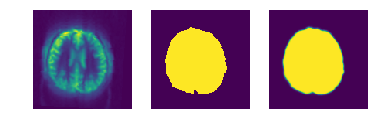

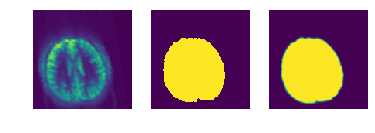

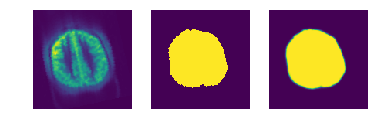

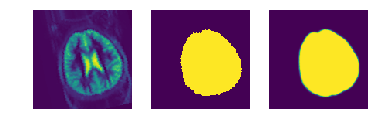

In [32]:
img = val_image_generator.next()
msk = val_mask_generator.next()
pre = model.predict(img)
for i in range(batch_size):
    fig, axes = plt.subplots(1, 3)
    axes[0].set_axis_off()
    axes[0].imshow(img[i].reshape(img[0].shape[:-1]))
    axes[1].set_axis_off()
    axes[1].imshow(msk[i].reshape(img[0].shape[:-1]))
    axes[2].set_axis_off()
    axes[2].imshow(pre[i].reshape(img[0].shape[:-1]))
plt.show()